In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import datetime, timedelta

In [ ]:
# Define the ticker symbol and the period for which you want the data
ticker_symbol = 'RELIANCE.NS'
start_date = '2010-01-01'
end_date = '2024-06-15'

# Fetch the data from Yahoo Finance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the dataset
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,498.814209,498.814209,467.155457,491.682404,440.421967,38323043
2010-01-05,525.695618,525.695618,487.065033,489.488007,438.456329,10696412
2010-01-06,493.693939,500.368591,489.465149,497.397003,445.540833,11845880
2010-01-07,497.397003,509.740479,492.825348,505.648834,452.932281,13098960
2010-01-08,506.540314,509.191895,501.054321,504.323059,451.744781,7555074


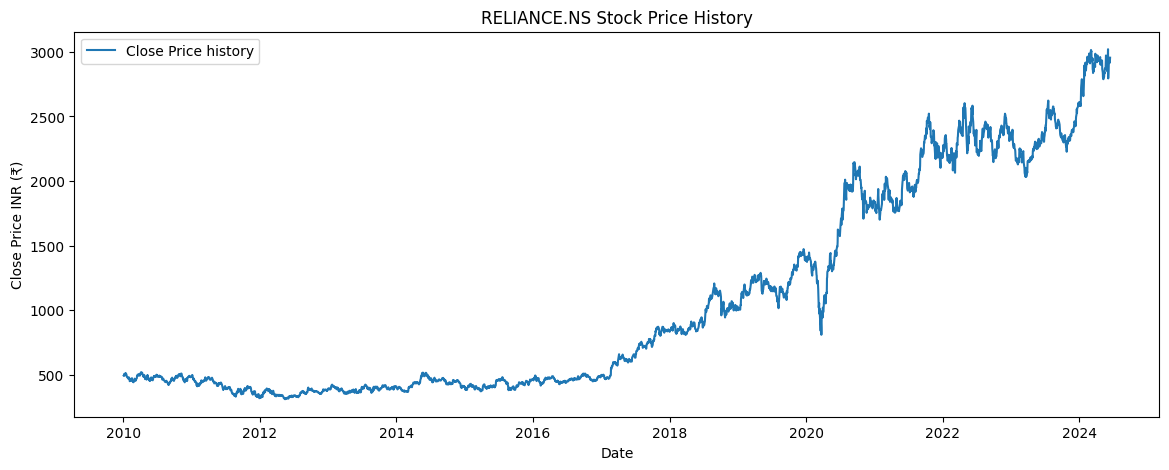

In [ ]:
# Visualize the closing price history
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price history')
plt.title(f'{ticker_symbol} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₹)')
plt.legend()
plt.show()

# Creating a new dataframe with only the 'Close' column
data_close = data['Close']

# Convert the dataframe to a numpy array
dataset = data_close.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') #Validation split, verbose


In [ ]:
# Train the model
epochs = 75  # You can increase this number to improve model performance
batch_size = 32  # Increase the batch size for faster training

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)


Epoch 1/75
88/88 [==============================] - 23s 120ms/step - loss: 0.0029
Epoch 2/75
88/88 [==============================] - 6s 67ms/step - loss: 7.6520e-04
Epoch 3/75
88/88 [==============================] - 5s 62ms/step - loss: 5.3905e-04
Epoch 4/75
88/88 [==============================] - 7s 77ms/step - loss: 5.0827e-04
Epoch 5/75
88/88 [==============================] - 7s 79ms/step - loss: 5.0726e-04
Epoch 6/75
88/88 [==============================] - 11s 121ms/step - loss: 4.5702e-04
Epoch 7/75
88/88 [==============================] - 8s 91ms/step - loss: 4.6337e-04
Epoch 8/75
88/88 [==============================] - 6s 64ms/step - loss: 3.9188e-04
Epoch 9/75
88/88 [==============================] - 5s 60ms/step - loss: 4.0584e-04
Epoch 10/75
88/88 [==============================] - 10s 112ms/step - loss: 3.7180e-04
Epoch 11/75
88/88 [==============================] - 6s 70ms/step - loss: 3.8839e-04
Epoch 12/75
88/88 [==============================] - 7s 78ms/step - loss

In [ ]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'Root Mean Squared Error: {rmse}')


23/23 [==============================] - 1s 27ms/step
Root Mean Squared Error: 334.2725202645198


<ipython-input-19-6ce182db813d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


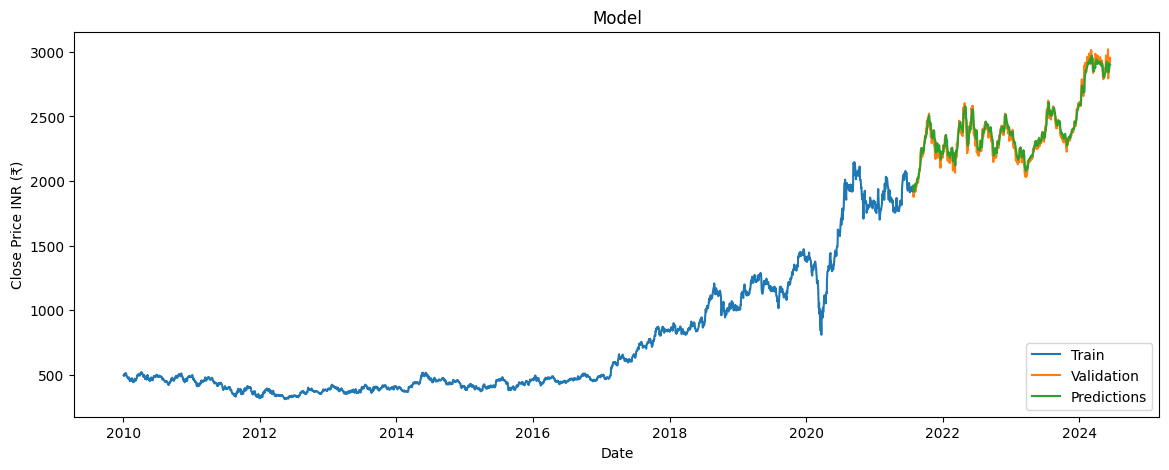

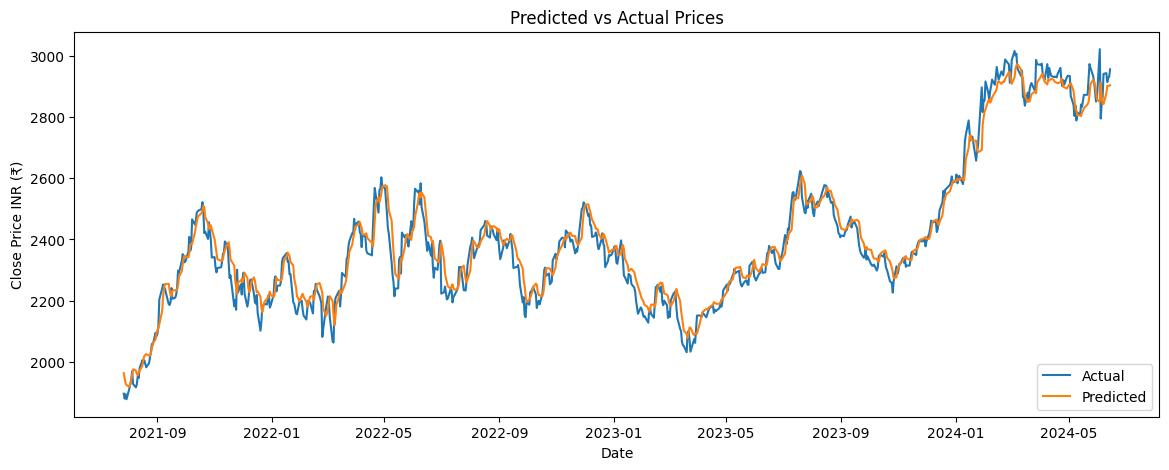

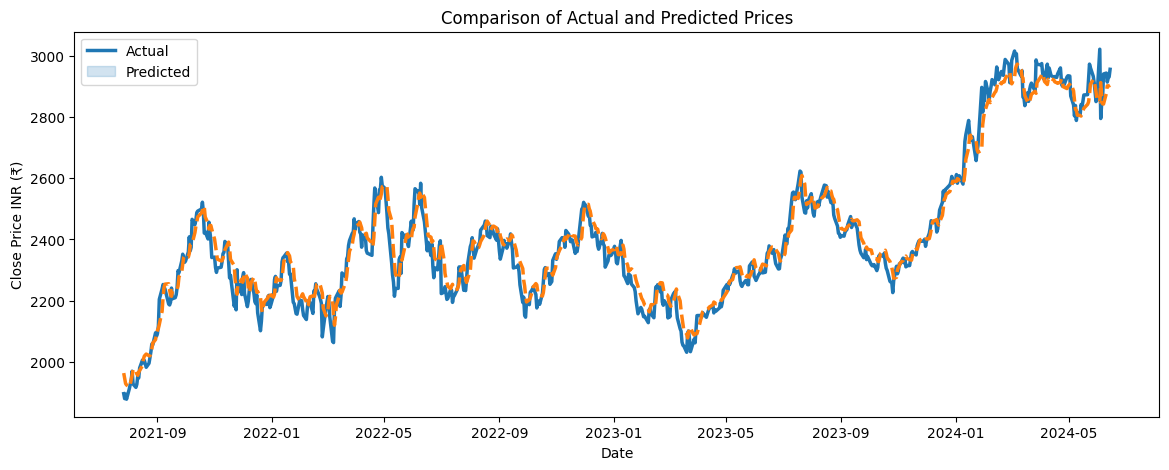

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(14, 5))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₹)')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Validation')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

# Plot the valid and predicted prices
plt.figure(figsize=(14, 5))
plt.title('Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₹)')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

# Plot a comparison of actual and predicted prices
plt.figure(figsize=(14, 5))
sns.lineplot(data=valid[['Close', 'Predictions']], palette="tab10", linewidth=2.5)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₹)')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()


In [ ]:
# Save the model
model.save('stock_price_lstm_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


new

In [ ]:
# Calculate model accuracy
mae = mean_absolute_error(valid['Close'], valid['Predictions'])
rmse = np.sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
mape = mean_absolute_percentage_error(valid['Close'], valid['Predictions']) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 34.36
Root Mean Squared Error (RMSE): 44.48
Mean Absolute Percentage Error (MAPE): 1.45%


1/1 [==============================] - 0s 33ms/step


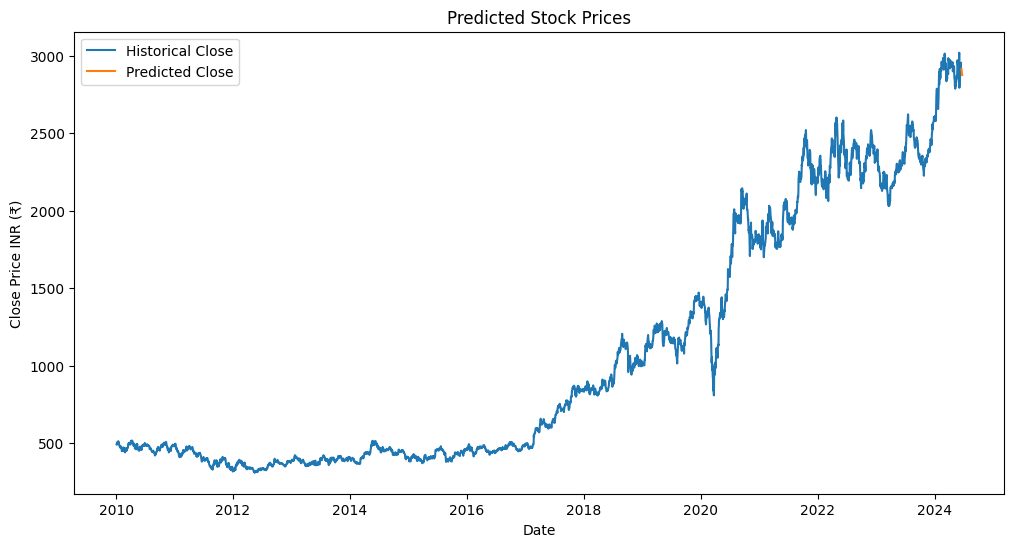

            Predicted Close
2024-06-17      2914.578613
2024-06-18      2906.040771
2024-06-19      2895.311768
2024-06-20      2885.144775
2024-06-21      2876.112061


In [ ]:
# Function to predict future stock prices
def predict_future_prices(model, scaler, last_60_days, future_days):
    future_prices = []
    current_sequence = last_60_days.copy()

    for _ in range(future_days):
        prediction = model.predict(current_sequence)
        future_prices.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    return future_prices

# Predict stock prices for a future date
future_date_str = '2024-06-19'  # Change to your desired future date
future_date = datetime.strptime(future_date_str, '%Y-%m-%d')
last_60_days = scaled_data[-60:].reshape(1, -1, 1)
future_days = (future_date - data.index[-1]).days

future_prices = predict_future_prices(model, scaler, last_60_days, future_days)

# Calculate future dates
date_range = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=future_days, freq='B')

# Create DataFrame with predicted prices and dates
future_prices_df = pd.DataFrame(future_prices, index=date_range, columns=['Predicted Close'])

# Plot the predicted prices leading up to the future date
plt.figure(figsize=(12, 6))
plt.plot(data_close, label='Historical Close')
plt.plot(future_prices_df, label='Predicted Close')
plt.title('Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₹)')
plt.legend()
plt.show()

print(future_prices_df)

1/1 [==============================] - 0s 28ms/step


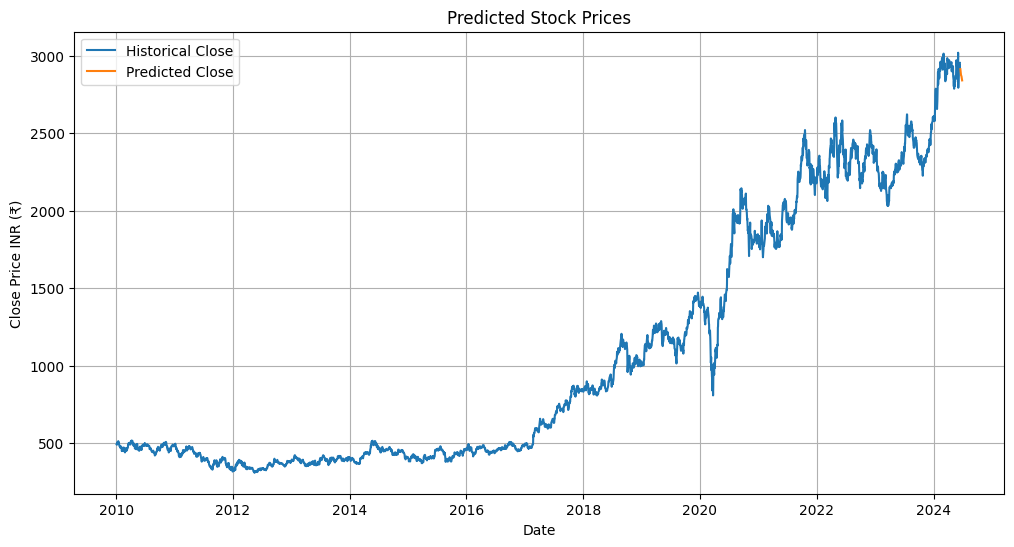

            Predicted Close
2024-06-17      2914.578613
2024-06-18      2906.040771
2024-06-19      2895.311768
2024-06-20      2885.144775
2024-06-21      2876.112061
2024-06-24      2868.097900
2024-06-25      2860.866699
2024-06-26      2854.203369
2024-06-27      2847.944336
2024-06-28      2841.978271


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def predict_future_prices(model, scaler, last_60_days, future_days):
    future_prices = []
    current_sequence = last_60_days.copy()

    for _ in range(future_days):
        prediction = model.predict(current_sequence)
        future_prices.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    return future_prices

future_date_str = '2024-06-19'
future_date = datetime.strptime(future_date_str, '%Y-%m-%d')
last_60_days = scaled_data[-60:].reshape(1, -1, 1)
future_days = 10  # Number of days to predict into the future

future_prices = predict_future_prices(model, scaler, last_60_days, future_days)

date_range = pd.date_range(start=data_close.index[-1] + timedelta(days=1), periods=future_days, freq='B')

future_prices_df = pd.DataFrame(future_prices, index=date_range, columns=['Predicted Close'])

plt.figure(figsize=(12, 6))
plt.plot(data_close, label='Historical Close')
plt.plot(future_prices_df, label='Predicted Close')
plt.title('Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price INR (₹)')
plt.legend()
plt.grid(True)
plt.show()

print(future_prices_df)
